# Inference & Visualization for 3D Lung Segmentation

This notebook runs inference on a few CT cases and visualizes Ground Truth (GT) vs Predicted masks.

- Uses existing pipeline: `src/inference.py` and `src/visualize.py`
- Overlays (GT in red, Pred in blue) on axial/coronal/sagittal slices
- Optional 3D isosurface view of the 



In [2]:
import os, glob,sys
import nibabel as nib
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt

try:
    import pyvista as pv
except Exception as e:
    print("PyVista not available:", e)
    raise


PROJECT_ROOT = "/Users/luigidaddario/Documents/GitHub/biomedical_imaging"

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.inference import run_inference
from src.visualize import plot_overlays, plot_3d_mask

DATA_DIR = os.path.join(PROJECT_ROOT, "data", "lctsc")
MODEL_PATH = os.path.join(PROJECT_ROOT, "results", "models", "run_20250904-145824", "best_model.keras")  # <- change to your model
OUT_DIR = os.path.join(PROJECT_ROOT, "results", "figures", "nb")
os.makedirs(OUT_DIR, exist_ok=True)

print("Data dir:", DATA_DIR)
print("Model path:", MODEL_PATH)
print("Output dir:", OUT_DIR)


Data dir: /Users/luigidaddario/Documents/GitHub/biomedical_imaging/data/lctsc
Model path: /Users/luigidaddario/Documents/GitHub/biomedical_imaging/results/models/run_20250904-145824/best_model.keras
Output dir: /Users/luigidaddario/Documents/GitHub/biomedical_imaging/results/figures/nb


## Utility Functions

In [ ]:
def pyvista_mask_mesh(binary_mask: np.ndarray, spacing):
    # binary_mask shape: (D,H,W)
    grid = pv.ImageData()
    d, h, w = binary_mask.shape
    grid.dimensions = np.array([w, h, d])  # PyVista -> (nx, ny, nz)
    grid.spacing = (float(spacing[0]), float(spacing[1]), float(spacing[2]))
    grid.origin = (0.0, 0.0, 0.0)

    scalars = binary_mask.astype(np.uint8).transpose(2,1,0).ravel(order='F')
    grid.point_data["values"] = scalars
    return grid.contour(isosurfaces=[0.5], scalars="values")


def pyvista_ct_volume(ct_array: np.ndarray, spacing):
    # ct_array shape: (D,H,W)
    grid = pv.ImageData()
    d, h, w = ct_array.shape
    grid.dimensions = np.array([w, h, d])
    grid.spacing = (float(spacing[0]), float(spacing[1]), float(spacing[2]))
    grid.origin = (0.0, 0.0, 0.0)
    scalars = ct_array.astype(np.float32).transpose(2,1,0).ravel(order='F')
    grid.point_data["values"] = scalars
    return grid

In [ ]:
def dice_coef(y_true, y_pred, eps=1e-6):
    inter = np.sum((y_true>0) & (y_pred>0))
    tot = np.sum(y_true>0) + np.sum(y_pred>0)
    return (2*inter + eps) / (tot + eps)

def iou_coef(y_true, y_pred, eps=1e-6):
    inter = np.sum((y_true>0) & (y_pred>0))
    union = np.sum((y_true>0) | (y_pred>0))
    return (inter + eps) / (union + eps)

## Pick few cases to visualize

In [3]:
cases = sorted([d for d in glob.glob(os.path.join(DATA_DIR, "*")) if os.path.isdir(d)])
print("Found", len(cases), "cases")

N = 3  # how many to visualize
cases = cases[:N]
for c in cases:
    print(os.path.basename(c))


Found 60 cases
02219
02503
02580


## 3D visualization with PyVista

 If running in Jupyter Lab classic, ensure widgets and backend are set up:
 - pip install "pyvista[trame]" ipywidgets
 - In some setups: `pv.set_jupyter_backend('trame')`

In [ ]:
#We render 3D for each case already processed 
for case_dir in cases:
    case_id = os.path.basename(case_dir)
    pred_path = os.path.join(OUT_DIR, f"{case_id}_pred_mask.nii.gz")
    if not os.path.exists(pred_path):
        print(f"Skipping {case_id}: prediction NIfTI not found at {pred_path}")
        continue

    nii = nib.load(pred_path)
    pred = nii.get_fdata().astype(np.float32)
    binary = (pred > 0.5).astype(np.uint8)

    #spacing and CT for volume rendering
    ct_img = nib.load(os.path.join(case_dir, "ct.nii.gz"))
    spacing = ct_img.header.get_zooms()[:3]
    ct = ct_img.get_fdata().astype(np.float32)

    wmin, wmax = -1000, 300
    ct_clip = np.clip(ct, wmin, wmax)
    ct_norm = (ct_clip - ct_clip.min()) / (ct_clip.max() - ct_clip.min() + 1e-8)

    try:
        mesh = pyvista_mask_mesh(binary, spacing=spacing)
        vol = pyvista_ct_volume(ct_norm, spacing=spacing)
    except Exception as e:
        print(f"PyVista preprocessing failed for {case_id}:", e)
        continue

    # 3D mask rendering
    p1 = pv.Plotter(off_screen=True)
    p1.set_background('white')
    p1.add_mesh(mesh, color='tab:blue', opacity=0.2)
    p1.camera_position = 'xz'
    p1.camera.azimuth = 180
    out_mask = os.path.join(OUT_DIR, f"{case_id}_3d_pv.png")
    try:
        p1.show(screenshot=out_mask)
        print(f"Saved 3D mask snapshot: {out_mask}")
    except Exception as e:
        print(f"Mask rendering failed for {case_id}:", e)
    finally:
        p1.close()

    p2 = pv.Plotter(off_screen=True)
    p2.set_background('white')
    opacity = [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    p2.add_volume(vol, scalars="values", cmap="bone", opacity=opacity, shade=True)
    p2.camera_position = 'xz'
    p2.camera.azimuth = 180
    out_ct = os.path.join(OUT_DIR, f"{case_id}_ct3d_pv.png")
    try:
        p2.show(screenshot=out_ct)
        print(f"Saved 3D CT snapshot: {out_ct}")
    except Exception as e:
        print(f"CT rendering failed for {case_id}:", e)
    finally:
        p2.close()



Case: 02219
[OK] Salvato mask: /Users/luigidaddario/Documents/GitHub/biomedical_imaging/results/figures/nb/02219_pred_mask.nii.gz
[OK] Salvato prob:  /Users/luigidaddario/Documents/GitHub/biomedical_imaging/results/figures/nb/02219_pred_prob.nii.gz
Metrics — Dice: 0.2008 | IoU: 0.1116


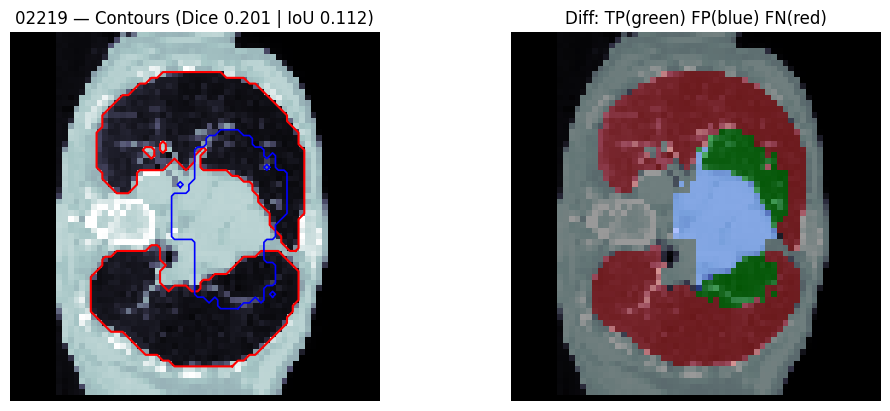


Case: 02503
[OK] Salvato mask: /Users/luigidaddario/Documents/GitHub/biomedical_imaging/results/figures/nb/02503_pred_mask.nii.gz
[OK] Salvato prob:  /Users/luigidaddario/Documents/GitHub/biomedical_imaging/results/figures/nb/02503_pred_prob.nii.gz
Metrics — Dice: 0.1917 | IoU: 0.1060


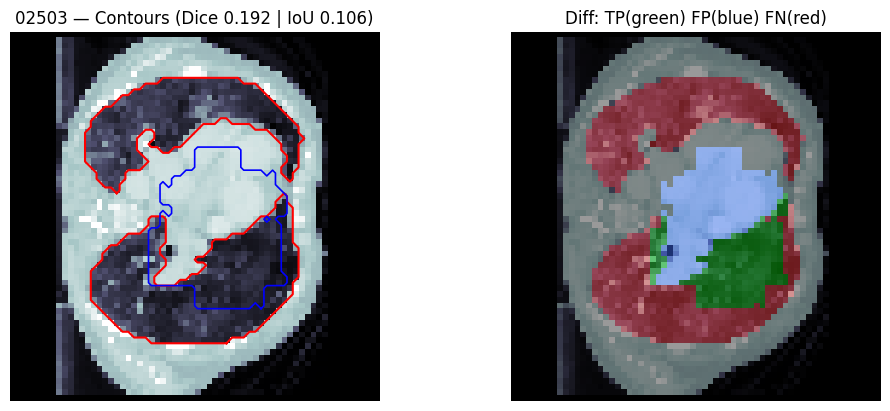


Case: 02580
[OK] Salvato mask: /Users/luigidaddario/Documents/GitHub/biomedical_imaging/results/figures/nb/02580_pred_mask.nii.gz
[OK] Salvato prob:  /Users/luigidaddario/Documents/GitHub/biomedical_imaging/results/figures/nb/02580_pred_prob.nii.gz
Metrics — Dice: 0.2319 | IoU: 0.1312


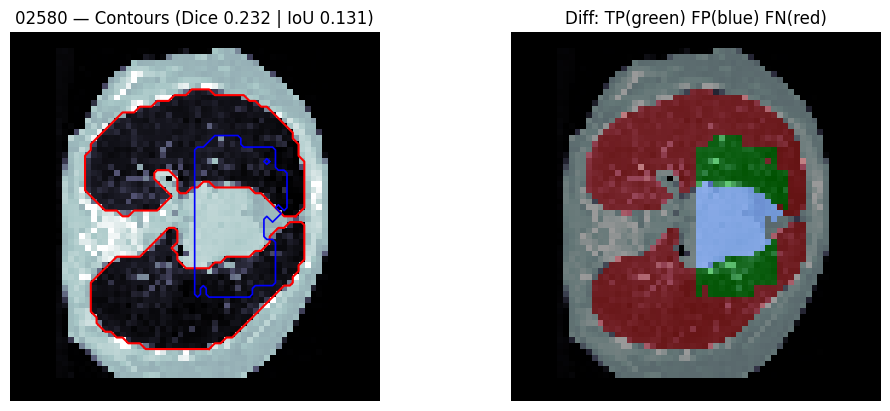

In [4]:
wmin, wmax = -1000, 300
thr = 0.5

for case_dir in cases:
    case_id = os.path.basename(case_dir)
    print(f"\nCase: {case_id}")

    out_mask_path = os.path.join(OUT_DIR, f"{case_id}_pred_mask.nii.gz")
    out_prob_path = os.path.join(OUT_DIR, f"{case_id}_pred_prob.nii.gz")

    run_inference(
        model_path=MODEL_PATH,
        input_path=case_dir,
        out_mask_path=out_mask_path,
        wmin=wmin, wmax=wmax,
        threshold=thr,
        save_prob_path=out_prob_path,
    )

    ct = nib.load(os.path.join(case_dir, "ct.nii.gz")).get_fdata().astype(np.float32)
    gt = nib.load(os.path.join(case_dir, "lung.nii.gz")).get_fdata().astype(np.float32)
    pred = nib.load(out_mask_path).get_fdata().astype(np.float32)

    #Normalize CT for display
    ct_clip = np.clip(ct, wmin, wmax)
    ct_norm = (ct_clip - ct_clip.min()) / (ct_clip.max() - ct_clip.min() + 1e-8)

    #2D overlays
    plot_overlays(ct_norm, mask_gt=(gt>0).astype(np.float32), mask_pred=(pred>0).astype(np.float32),
                  title=f"{case_id}: GT (red) vs Pred (blue)",
                  out_path=os.path.join(OUT_DIR, f"{case_id}_slices.png"),
                  window=(0.0, 1.0))

    #3D view (prediction)
    spacing = nib.load(os.path.join(case_dir, "ct.nii.gz")).header.get_zooms()[:3]
    plot_3d_mask((pred>0.5).astype(np.float32), spacing=spacing,
                 out_path=os.path.join(OUT_DIR, f"{case_id}_3d.png"))


## Explicit GT vs Pred comparison (metrics + contours + diff map)

In [ ]:
 dice = dice_coef(gt, pred)
    iou  = iou_coef(gt, pred)
    print(f"Metrics — Dice: {dice:.4f} | IoU: {iou:.4f}")

    coords = np.argwhere(gt>0)
    z = int(np.mean(coords[:,2])) if coords.size else gt.shape[2]//2

    ct_slice = ct_norm[:,:,z]
    gt_slice = (gt[:,:,z]>0).astype(np.uint8)
    pd_slice = (pred[:,:,z]>0).astype(np.uint8)

    #Contours
    gt_cnt = measure.find_contours(gt_slice, 0.5)
    pd_cnt = measure.find_contours(pd_slice, 0.5)

    fig, ax = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)

    #Overlay with contours
    ax[0].imshow(ct_slice, cmap="bone", vmin=0, vmax=1)
    for c in gt_cnt: ax[0].plot(c[:,1], c[:,0], color="red", linewidth=1.5, label="GT")
    for c in pd_cnt: ax[0].plot(c[:,1], c[:,0], color="blue", linewidth=1.2, label="Pred")
    ax[0].set_title(f"{case_id} — Contours (Dice {dice:.3f} | IoU {iou:.3f})")
    ax[0].axis("off")

    # Diff map: TP=green, FP=blue, FN=red
    tp = (gt_slice==1) & (pd_slice==1)
    fp = (gt_slice==0) & (pd_slice==1)
    fn = (gt_slice==1) & (pd_slice==0)
    diff_rgb = np.zeros((*gt_slice.shape,3), dtype=float)
    diff_rgb[tp] = [0.0, 0.8, 0.0]
    diff_rgb[fp] = [0.2, 0.4, 1.0]
    diff_rgb[fn] = [1.0, 0.2, 0.2]
    ax[1].imshow(ct_slice, cmap="bone", vmin=0, vmax=1)
    ax[1].imshow(diff_rgb, alpha=0.4)
    ax[1].set_title("Diff: TP(green) FP(blue) FN(red)")
    ax[1].axis("off")

    fig.savefig(os.path.join(OUT_DIR, f"{case_id}_compare.png"), dpi=150)
    plt.show()
    plt.close(fig)